# CIFAR10 으로 GAN 학습시키기
----------------------------------
### 목차
1. 데이터셋 구성
2. 전처리
3. 생성자 모델 구현
4. 판별자 모델 구현
5. 손실함수 & 최적화 함수 구현
6. 상세기능 구현
7. 학습
8. 성능 개선

In [1]:
import tensorflow as tf
import imageio
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 데이터셋 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


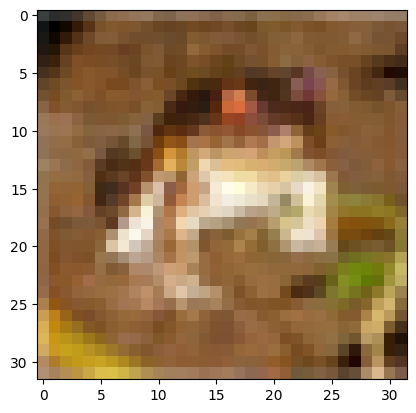

In [4]:
# 이미지 시각
plt.imshow(train_x[0])
plt.show()

In [5]:
# 레이블 flatten
train_labels_flat = train_y.flatten()
test_labels_flat = test_y.flatten()

# 클래스당 이미지 수
unique, counts = np.unique(train_labels_flat, return_counts=True)
train_distribution = dict(zip(unique, counts))
print("Training set distribution:", train_distribution)

# 클래스당 테스트 이미지 수
unique, counts = np.unique(test_labels_flat, return_counts=True)
test_distribution = dict(zip(unique, counts))
print("Test set distribution:", test_distribution)

Training set distribution: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Test set distribution: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [6]:
class_images = {}

for image, label in zip(train_x, train_labels_flat):
    if label not in class_images:
        class_images[label] = image

    if len(class_images) == 10:
        break

In [7]:
class_images[1]

array([[[170, 180, 198],
        [168, 178, 196],
        [177, 185, 203],
        ...,
        [162, 179, 215],
        [158, 178, 214],
        [157, 177, 212]],

       [[168, 181, 198],
        [172, 185, 201],
        [171, 183, 200],
        ...,
        [159, 177, 212],
        [156, 176, 211],
        [154, 174, 209]],

       [[154, 170, 186],
        [149, 165, 181],
        [129, 144, 162],
        ...,
        [161, 178, 214],
        [157, 177, 212],
        [154, 174, 209]],

       ...,

       [[ 74,  84,  80],
        [ 76,  85,  81],
        [ 78,  85,  82],
        ...,
        [ 71,  75,  78],
        [ 68,  72,  75],
        [ 61,  65,  68]],

       [[ 68,  76,  77],
        [ 69,  77,  78],
        [ 72,  79,  78],
        ...,
        [ 76,  80,  83],
        [ 71,  75,  78],
        [ 71,  75,  78]],

       [[ 67,  75,  78],
        [ 68,  76,  79],
        [ 69,  75,  76],
        ...,
        [ 75,  79,  82],
        [ 71,  75,  78],
        [ 73,  77,  80]]

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# 클래스 이름을 key로 저장
named_class_images = {class_names[key]: value for key, value in class_images.items()}

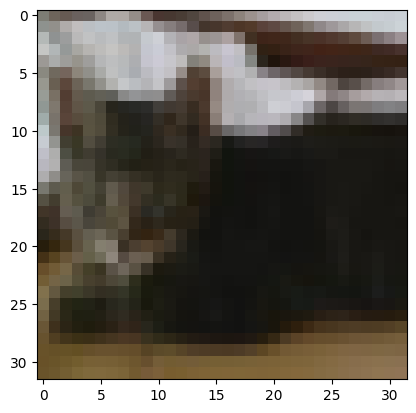

In [9]:
plt.imshow(named_class_images['cat'])
plt.show()

## Color Distribution

In [10]:
import cv2
from PIL import Image

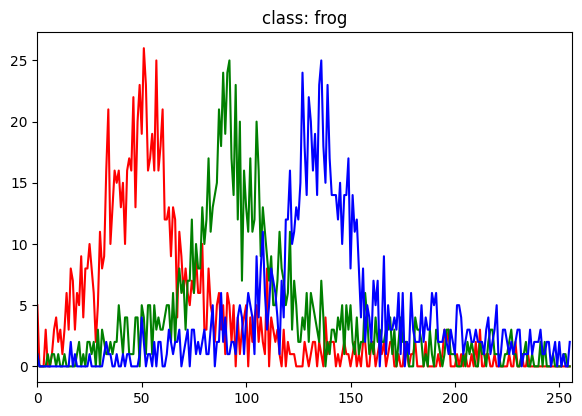

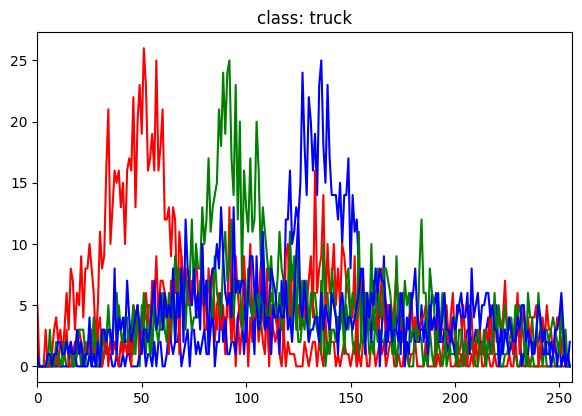

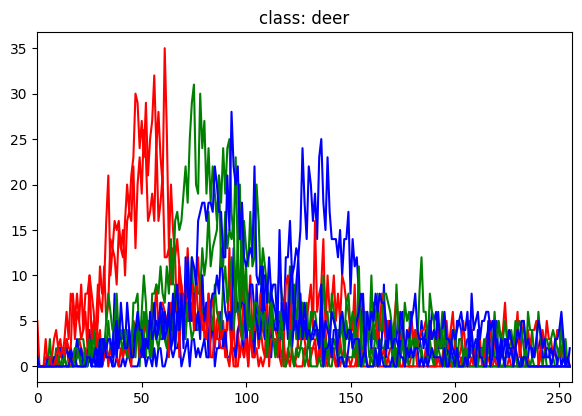

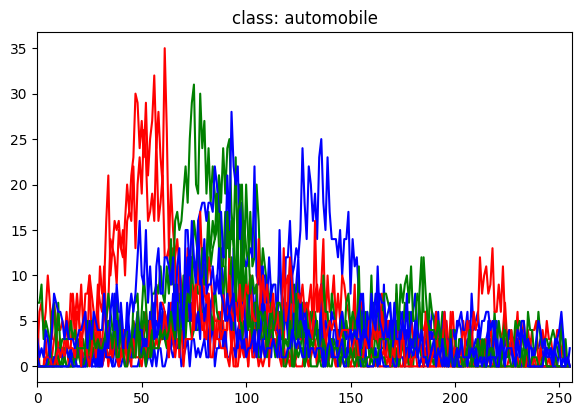

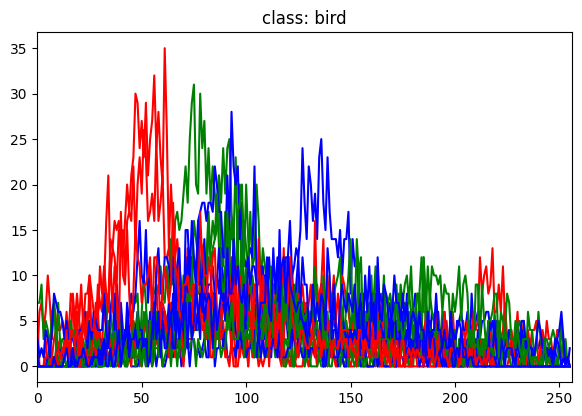

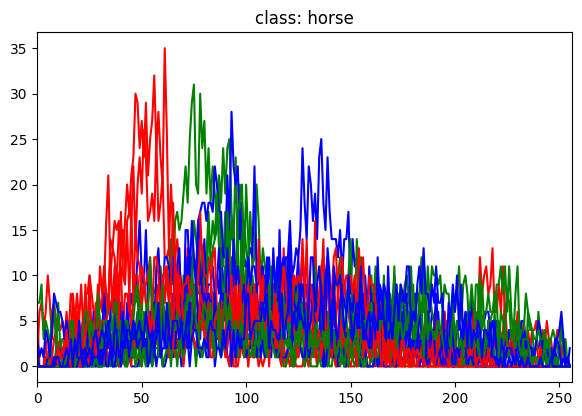

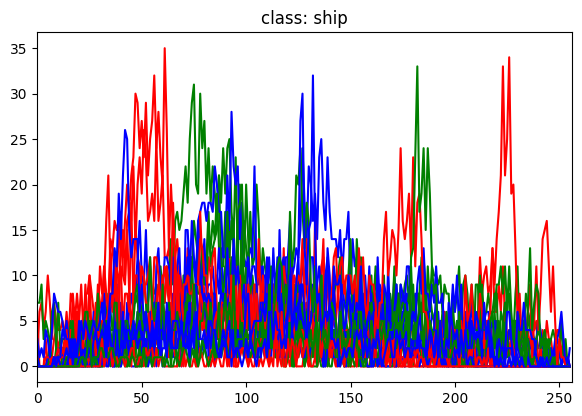

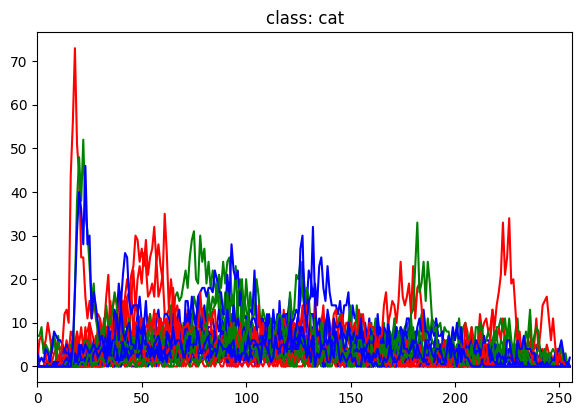

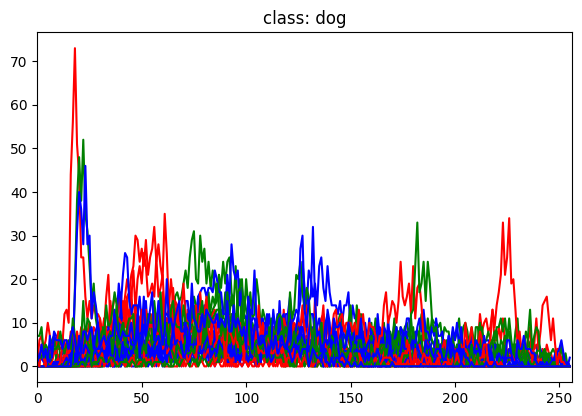

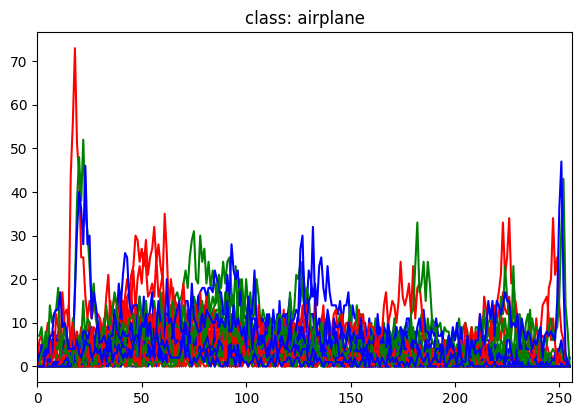

In [11]:
# 색 분포 그려보기
color_distributions = []

for type, img in named_class_images.items():
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 각 채널당 픽셀값 계산
    for i, col in enumerate(['r', 'g', 'b']):
        histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
        color_distributions.append((col, histogram))

    plt.figure(figsize=(40, 10))
    for col, histogram in color_distributions:
        plt.subplot(2, 5, 10)
        plt.plot(histogram, color=col)
        plt.xlim([0, 256])
        plt.title(f'class: {type}')

    plt.show()

## 간단한 전처리

In [12]:
# 이미지 정규화
train_x = np.array(list(map(lambda x: (x / 127.5) - 1, train_x)))

In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def resize_images(images):
#     resized_img = []
#     for image in images:
#         image = tf.image.resize(image, [32, 32])
#         resized_img.append(np.array(image))
#     return np.array(resized_img)

# # 원본 이미지 데이터가 있다고 가정
# # train_x = [원본 이미지 데이터]

# # 이미지 리사이징
# train_x = resize_images(train_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

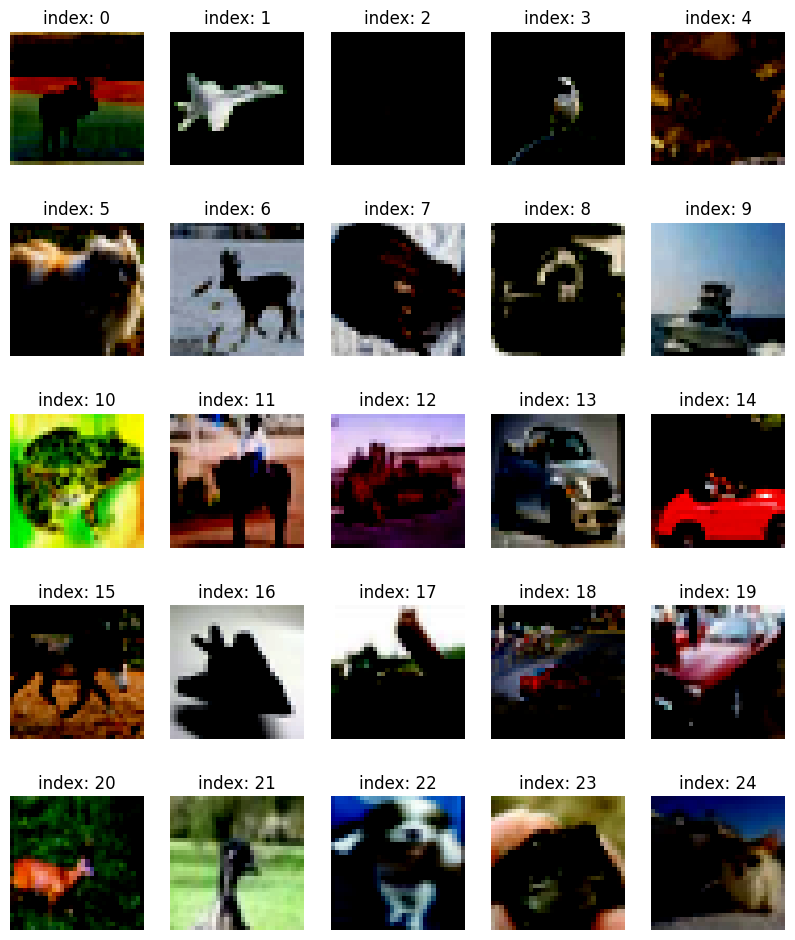

In [14]:
# 25개 사진을 랜덤으로 뽑아보기
import random

plt.figure(figsize=(10, 12))

for i in range(25):
    rand_int = random.randint(0, 100)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[rand_int], cmap='hsv')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [15]:
# 데이터를 섞기 위해 파라미터 설
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [16]:
# 훈련데이터 섞기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [18]:
# 모델 summary 확인
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [19]:
# 노이즈 벡터 만들기
noise = np.random.randint(100, size=100)

In [20]:
noise = noise.reshape(1, 100)
noise

array([[53, 11, 79, 48, 90, 72, 79, 99, 84, 42, 88, 47, 34, 62, 87, 16,
        95,  5, 22, 93, 22, 45,  5, 51, 45, 37, 53, 45, 39, 88, 17,  8,
        28, 21,  2, 10, 34, 47, 26, 43, 78, 83, 26, 92, 82, 87, 14, 15,
        19, 94, 33,  7, 42, 92, 36, 11, 41,  9, 85, 56,  2,  6, 32,  1,
         6, 58, 88,  9, 73, 26, 25, 60, 58, 73, 98, 71, 64, 99, 52,  3,
        35, 90, 92, 64, 94, 82, 44, 44, 99, 62, 38,  1, 92, 74, 35, 85,
        66, 78, 11, 90]])

In [21]:
# 훈련과 추론에서 BatchNorm 행동이달라 Training = False
generated_image = generator(noise, training=False)

# 예시: generated_image가 NumPy 배열일 때
adjusted_image = generated_image.numpy()
# adjusted_image = adjusted_image.astype(np.64)

# 결과 출력
print(adjusted_image)

[[[[ 0.14757255 -0.07235089  0.02031162]
   [-0.21993768  0.30900398  0.06920137]
   [-0.32023185  0.12265968  0.06681588]
   ...
   [ 0.08809309 -0.39169252  0.06335378]
   [-0.04325575 -0.04674487  0.23085956]
   [ 0.10705942  0.48186326  0.03232974]]

  [[ 0.0592      0.26822197  0.16719648]
   [-0.265066   -0.36675635  0.37544918]
   [-0.163024   -0.30621573 -0.00843603]
   ...
   [-0.22500974  0.9613895   0.734855  ]
   [ 0.12919596 -0.5201758   0.63395864]
   [-0.10794982 -0.31014913  0.79872197]]

  [[ 0.179462   -0.02689754 -0.06864193]
   [ 0.15060729 -0.17284426 -0.01313214]
   [ 0.18489522 -0.4074036   0.20892642]
   ...
   [-0.13139658 -0.66107166  0.31936628]
   [ 0.22570018  0.13356607 -0.18261051]
   [ 0.04731864  0.19549699  0.26820865]]

  ...

  [[ 0.44084212  0.45891342  0.4771725 ]
   [ 0.16317324  0.34667915  0.3623284 ]
   [-0.63640577 -0.4223323   0.7083808 ]
   ...
   [ 0.91203946  0.5527547   0.85919964]
   [-0.22616272  0.04180687 -0.4055561 ]
   [ 0.83403707 

- 참고링크:https://jrc-park.tistory.com/155

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


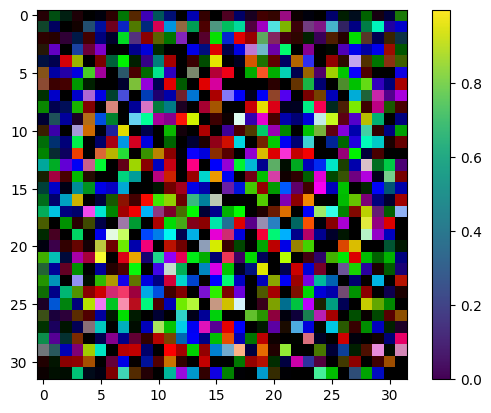

In [22]:
# 생성된 노이즈 이미지 뽑기
plt.imshow(adjusted_image[0])
plt.colorbar()
plt.show()

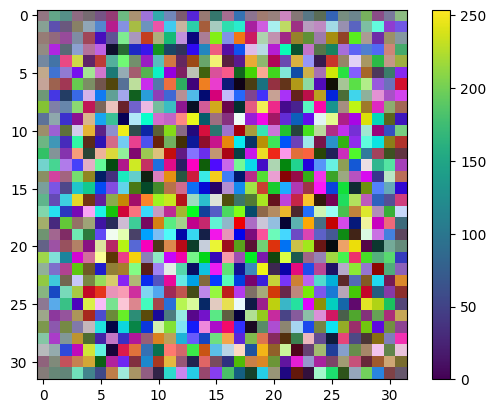

In [23]:
temp = tf.cast(generated_image[0]*127.5+127.5, tf.int64)
plt.imshow(temp)
plt.colorbar()
plt.show()

# 판별자 구현하기

In [24]:
# 모델 정의
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [26]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04821604]], dtype=float32)>

## 손실함수

In [27]:
# cross_entropy 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
# vector 변수는 모양, 이게 ones-Like에 들어간
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>

In [29]:
# 생성자 loss, fake output이 1에 수렴하도록
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
# 판별자 loss
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

## 평가하기

In [31]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [32]:
# 생성자, 판별자 따로 학습하기 때문에 두개의 optimizer 필
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [33]:
# (16, 100) 형상의 벡터를 만들기 위해 seed = 100 설
noise_dim = 100
num_examples_to_generate = 16

# # 노이즈 벡터 만들기
# noise = np.random.normal(0, 0.5, size=100)
# noise = noise.reshape(1, 100)
#     # 훈련과 추론에서 BatchNorm 행동이달라 Training = False
# generated_image = generator(noise, training=False)

# # 예시: generated_image가 NumPy 배열일 때
# adjusted_image = generated_image.numpy() * 127.5+127.5
# adjusted_image = adjusted_image.astype(np.int32)

# seed = np.random.normal(0, 0.9, size=1600)
# seed = seed.reshape(16, 100)
# seed = tf.convert_to_tensor(seed, dtype=tf.int32)
# seed.shape

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [34]:
# Train Step
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    # 노이즈 벡터 만들기
    noise = np.random.randint(100, size=100)
    noise = noise.reshape(1, 100)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [35]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0]))
        plt.axis('off')
        
    cwd = os.getcwd()
    folder_path = os.path.join(cwd, r'cifar10\generated_samples')
    # plt.savefig(os.path.join(folder_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)))

    plt.show()

In [36]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    cwd_b = os.getcwd()
    folder_path_b = os.path.join(cwd_b, r'cifar10\training_history')
    # plt.savefig(os.path.join(folder_path_b, 'train_history_{:04d}.png'.format(epoch)))
    plt.show()

In [37]:
cwd = os.getcwd()
checkpoint_dir = os.path.join(cwd, r'cifar10\training_checkpoints')

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 모델학습

In [38]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # if (epoch + 1) % save_every == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [39]:
save_every = 5
EPOCHS = 10

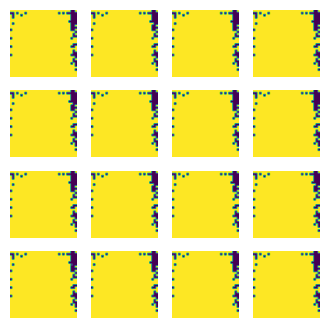

Time for training : 38 sec


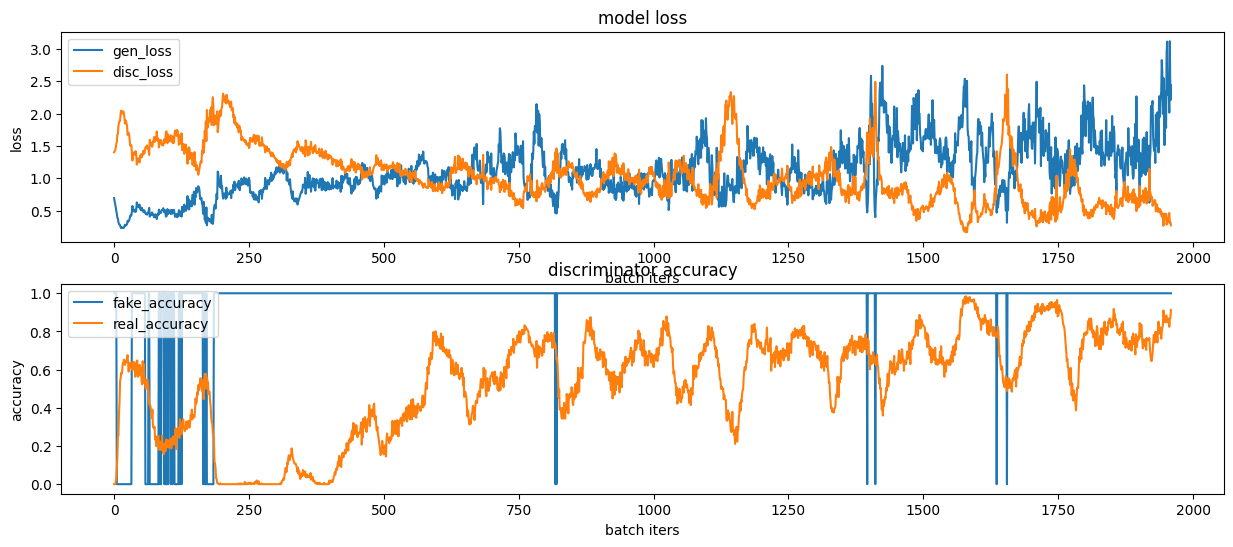

In [40]:
train(train_dataset, EPOCHS, save_every)

## 판별자 모델 바꿔보기
- l2 규제 추가
- leaky relu 에 alpha 값 추가

In [41]:
from tensorflow.keras import regularizers
# 모델 정의
def make_discriminator_model_reg():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.02))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=regularizers.L2(0.001)))
    model.add(layers.LeakyReLU(0.02))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [42]:
discriminator_reg = make_discriminator_model_reg()

discriminator_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [43]:
decision = discriminator_reg(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02947759]], dtype=float32)>

In [44]:
@tf.function
def train_step_reg(images):
    noise = np.random.normal(0, 0.1, size=100)
    noise = noise.reshape(1, 100)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator_reg(images, training=True)
        fake_output = discriminator_reg(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_reg.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_reg.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [45]:
def train_reg(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # if (epoch + 1) % save_every == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

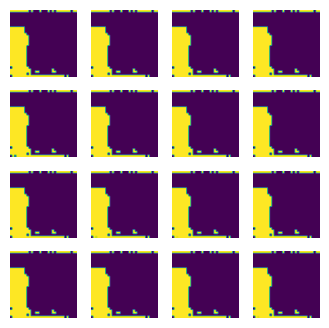

Time for training : 35 sec


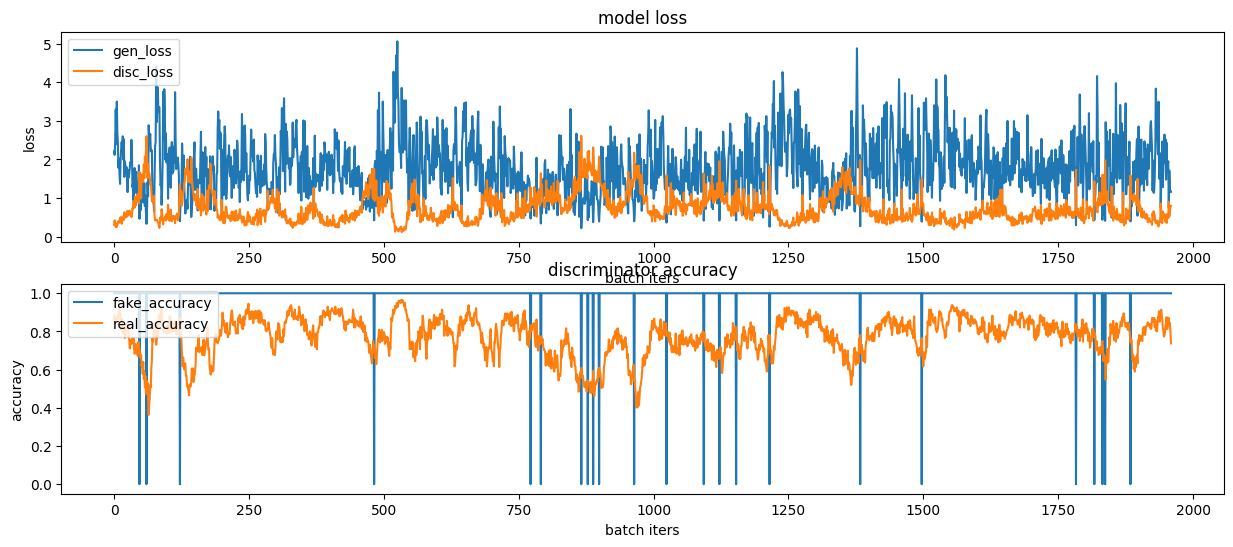

In [46]:
train_reg(train_dataset, EPOCHS, save_every)

## 생성자 모델 개선 해보기
1. con2dTranspose 레이어를 추가
2. filter 갯수 늘리기
3. noise 벡터는 tf.random.normal[ ,100] 다시 설정

In [47]:
def make_generator_model_betav2():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [48]:
# 모델 summary 확인
generator_betav2 = make_generator_model_betav2()

generator_betav2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)       

In [49]:
# 노이즈 벡터 만들기
noise_betav2 = tf.random.normal([1, 100])
# noise_dim = 255  # This should match the number of features expected by the generator
# batch_size = 256  # This appears to be your batch size

# Generate noise with the correct shape
# noise_betav2 = np.random.normal(size=(batch_size, noise_dim))

In [50]:
# 훈련과 추론에서 BatchNorm 행동이달라 Training = False
generated_image = generator_betav2(noise_betav2, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

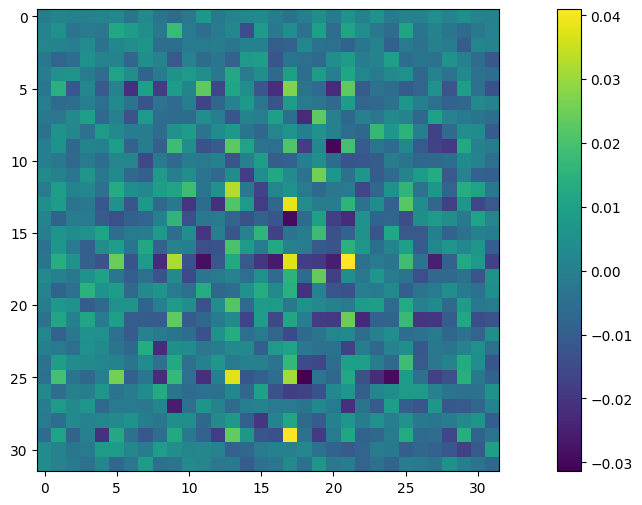

In [51]:
# 생성된 노이즈 이미지 뽑기
plt.imshow(generated_image[0, :, :, 0], cmap=None)
plt.colorbar()
plt.show()

In [52]:
# discriminator 재정의
discriminator_betav2 = make_discriminator_model()

discriminator_betav2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [53]:
# Train Step
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step_betav2(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_betav2(noise, training=True)

        real_output = discriminator_betav2(images, training=True)
        fake_output = discriminator_betav2(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_betav2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_betav2.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_betav2.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_betav2.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [54]:
cwd = os.getcwd()
checkpoint_dir_betav2 = os.path.join(cwd, r'cifar10\training_checkpoints')

checkpoint_prefix_betav2 = os.path.join(checkpoint_dir_betav2, "ckpt")
checkpoint_betav2 = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [55]:
def train_betav2(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_betav2(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_betav2, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # if (epoch + 1) % save_every == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_betav2, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [56]:
EPOCHS = 40
save_every =5

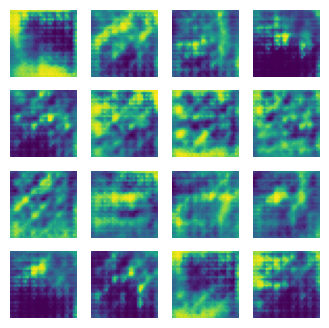

Time for training : 455 sec


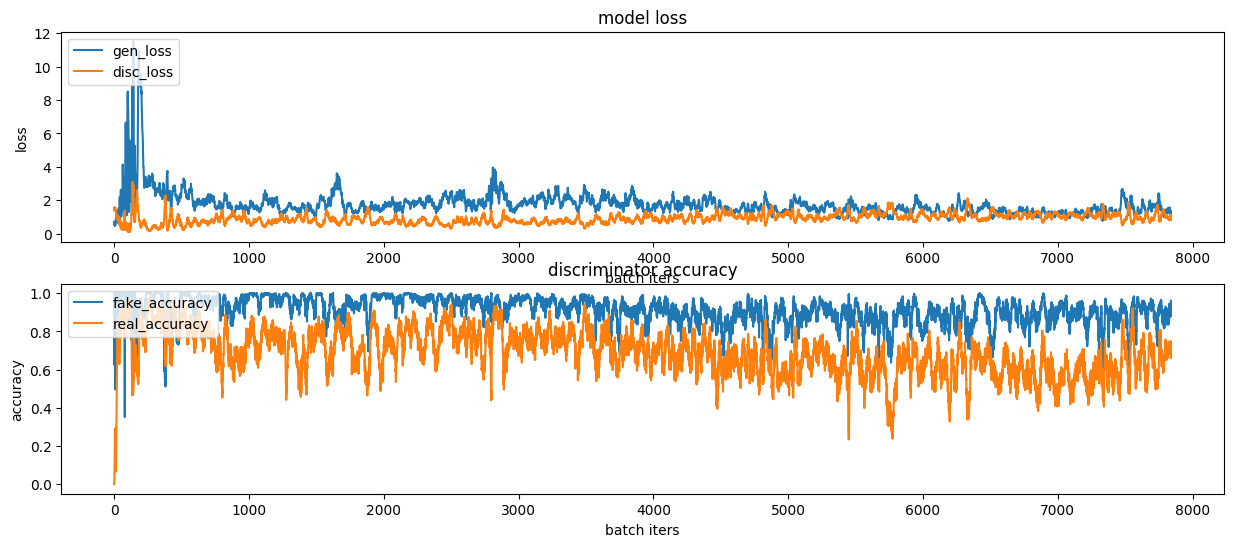

In [57]:
train_betav2(train_dataset, EPOCHS, save_every)

## 노이즈 벡터 feature를 늘려보기

In [58]:
def make_generator_model_beta():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(255,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [59]:
# 모델 summary 확인
generator_beta = make_generator_model_beta()

generator_beta.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16384)             4177920   
                                                                 
 batch_normalization_7 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 128)       

In [60]:
# 노이즈 벡터 만들기
# noise_beta = tf.random.normal([1, 255])
noise_dim = 255  # This should match the number of features expected by the generator
batch_size = 256  # This appears to be your batch size

# Generate noise with the correct shape
noise_beta = np.random.normal(size=(batch_size, noise_dim))

In [61]:
# 훈련과 추론에서 BatchNorm 행동이달라 Training = False
generated_image = generator_beta(noise_beta, training=False)
generated_image.shape

TensorShape([256, 32, 32, 3])

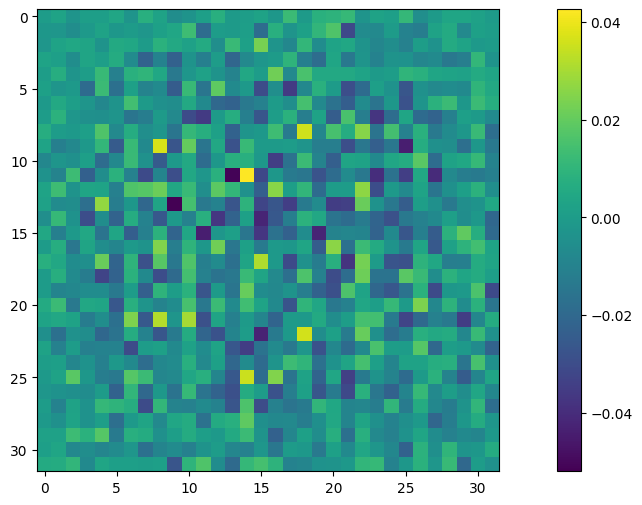

In [62]:
# 생성된 노이즈 이미지 뽑기
plt.imshow(generated_image[0, :, :, 0], cmap=None)
plt.colorbar()
plt.show()

In [63]:
# discriminator 재정의
discriminator_beta = make_discriminator_model()

discriminator_beta.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)             

In [64]:
# Train Step
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step_beta(images):
    noise = tf.random.normal([256, 255])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_beta(noise, training=True)

        real_output = discriminator_beta(images, training=True)
        fake_output = discriminator_beta(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_beta.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_beta.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_beta.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_beta.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [65]:
checkpoint_dir_beta = os.path.join(cwd, r'cifar10\training_checkpoints')

checkpoint_prefix_beta = os.path.join(checkpoint_dir, "ckpt")
checkpoint_beta = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [66]:
# (16, 100) 형상의 벡터를 만들기 위해 seed = 100 설
noise_dim_beta = 255
num_examples_to_generate = 16

seed_beta = tf.random.normal([num_examples_to_generate, noise_dim])
seed_beta.shape

TensorShape([16, 255])

In [67]:
def generate_and_save_images_beta(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap=None)
        plt.axis('off')

    cwd = os.getcwd()
    folder_path = os.path.join(cwd, r'cifar10\generated_samples')
    # plt.savefig(os.path.join(folder_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)))

    plt.show()

In [68]:
def train_beta(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_beta(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images_beta(generator_beta, epoch+1, it+1, seed_beta)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # if (epoch + 1) % save_every == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images_beta(generator_beta, epochs, it, seed_beta)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [69]:
save_every = 5
EPOCHS = 40

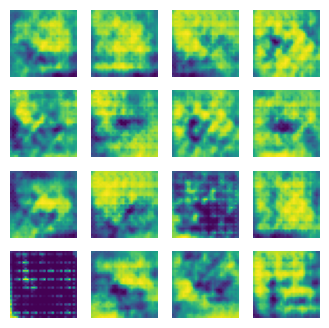

Time for training : 457 sec


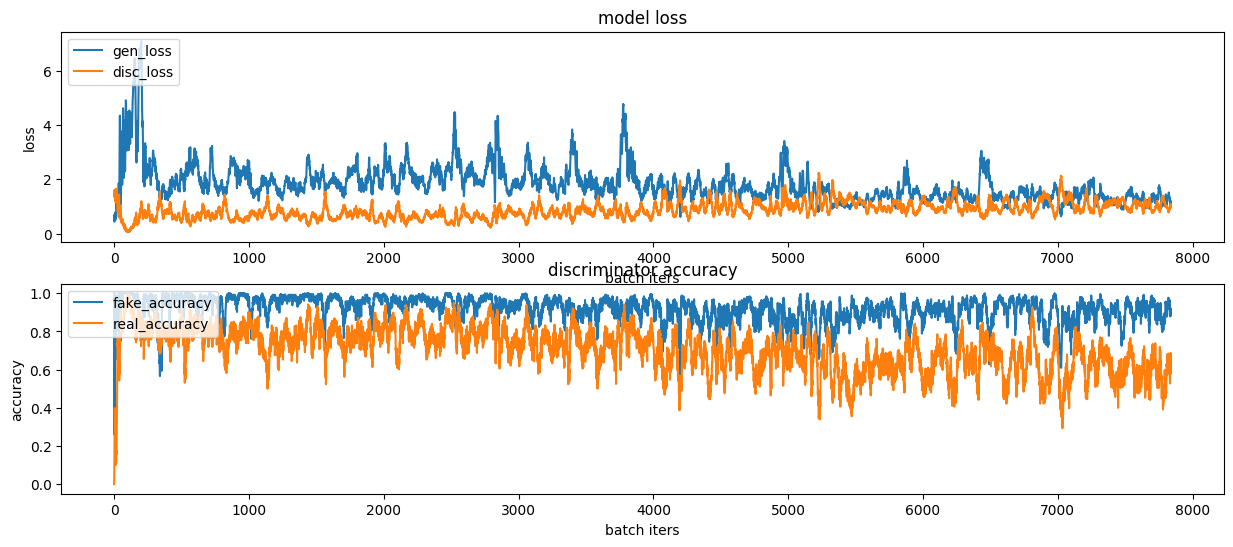

In [70]:
train_beta(train_dataset, EPOCHS, save_every)

## Learning Rate Schedule 적용해보기

In [71]:
def make_generator_model_betav3():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(255,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [72]:
# 모델 summary 확인
generator_betav3 = make_generator_model_betav3()

generator_betav3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16384)             4177920   
                                                                 
 batch_normalization_11 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 128)       

In [73]:
# 노이즈 벡터 만들기
# noise_beta = tf.random.normal([1, 255])
noise_dim = 255  # This should match the number of features expected by the generator
batch_size = 256  # This appears to be your batch size

# Generate noise with the correct shape
noise_betav3 = np.random.normal(size=(batch_size, noise_dim))

In [74]:
# 훈련과 추론에서 BatchNorm 행동이달라 Training = False
generated_imagev3 = generator_betav3(noise_betav3, training=False)
generated_imagev3.shape

TensorShape([256, 32, 32, 3])

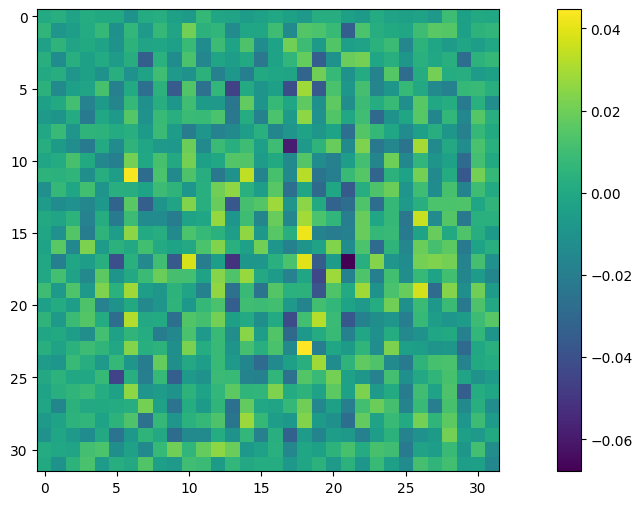

In [75]:
# 생성된 노이즈 이미지 뽑기
plt.imshow(generated_imagev3[0, :, :, 0], cmap=None)
plt.colorbar()
plt.show()

In [76]:
# discriminator 재정의
discriminator_beta = make_discriminator_model()

discriminator_beta.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)             

In [77]:
# 생성자, 판별자 따로 학습하기 때문에 두개의 optimizer 필
initial_learning_rate = 0.0002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [78]:
# Train Step
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step_betav3(images):
    noise = tf.random.normal([256, 255])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_betav3(noise, training=True)

        real_output = discriminator_beta(images, training=True)
        fake_output = discriminator_beta(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_betav3.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_beta.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_betav3.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_beta.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [79]:
checkpoint_dir_betav3 = os.path.join(cwd, r'cifar10\training_checkpoints')

checkpoint_prefix_betav3 = os.path.join(checkpoint_dir_betav3, "ckpt")
checkpoint_betav3 = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [80]:
def train_betav3(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_betav3(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images_beta(generator_betav3, epoch+1, it+1, seed_beta)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # if (epoch + 1) % save_every == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images_beta(generator_betav3, epochs, it, seed_beta)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [81]:
save_every = 5
EPOCHS = 40

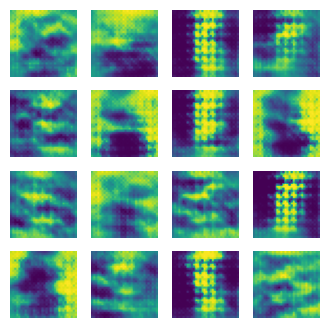

Time for training : 458 sec


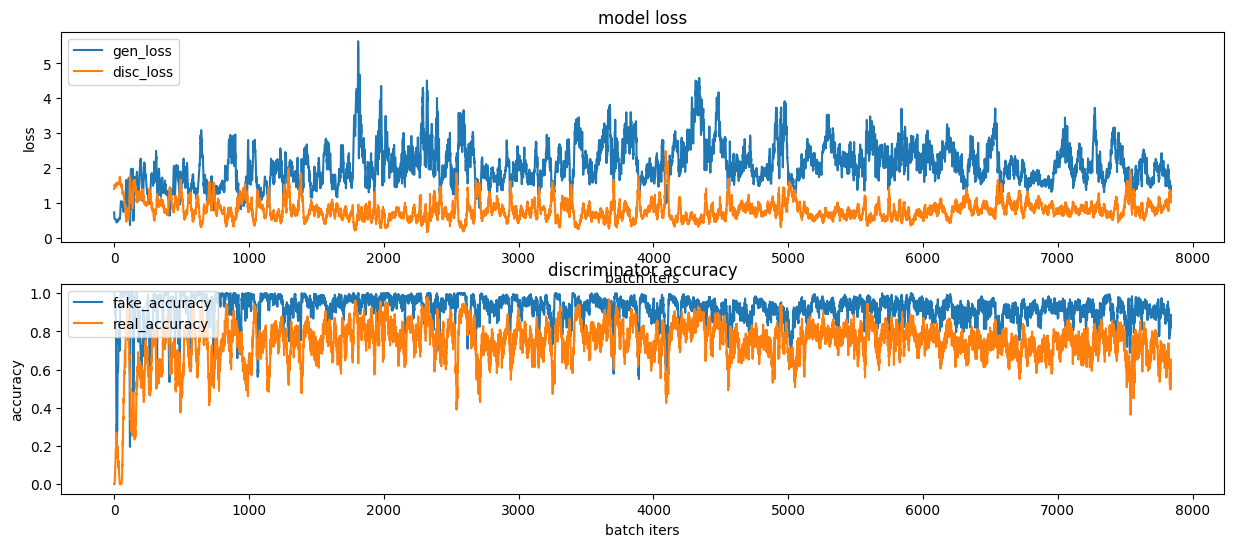

In [82]:
train_betav3(train_dataset, EPOCHS, save_every)

## Kernel 사이즈를  바꿔보기
- learning rate schedule은 큰 영향이 없어 스킵
- kernel은 4x4로 시도

In [83]:
def make_generator_model_betav4():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(255,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [84]:
# 모델 summary 확인
generator_betav4 = make_generator_model_betav4()

generator_betav4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16384)             4177920   
                                                                 
 batch_normalization_15 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 8, 8, 128)        524288    
 Transpose)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 8, 8, 128)       

In [85]:
# 노이즈 벡터 만들기
# noise_beta = tf.random.normal([1, 255])
noise_dim = 255  # This should match the number of features expected by the generator
batch_size = 256  # This appears to be your batch size

# Generate noise with the correct shape
noise_betav4 = np.random.normal(size=(batch_size, noise_dim))

In [86]:
# 훈련과 추론에서 BatchNorm 행동이달라 Training = False
generated_imagev4 = generator_betav4(noise_betav4, training=False)
generated_imagev4.shape

TensorShape([256, 32, 32, 3])

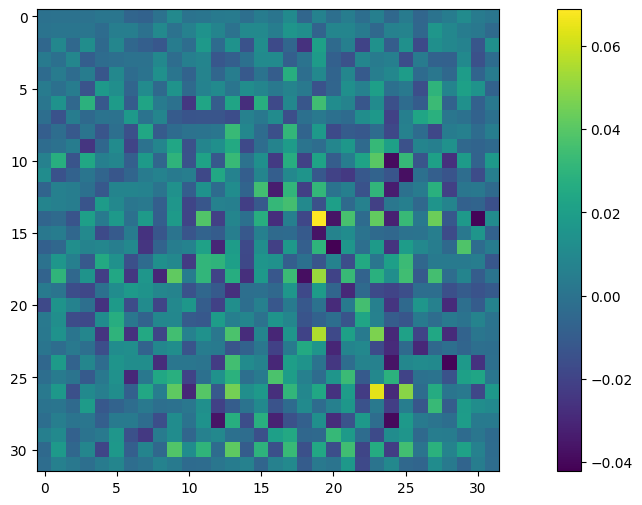

In [87]:
# 생성된 노이즈 이미지 뽑기
plt.imshow(generated_imagev4[0, :, :, 0], cmap=None)
plt.colorbar()
plt.show()

In [88]:
# discriminator 재정의
discriminator_beta = make_discriminator_model()

discriminator_beta.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)            

In [89]:
# Train Step
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step_betav4(images):
    noise = tf.random.normal([256, 255])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_betav4(noise, training=True)

        real_output = discriminator_beta(images, training=True)
        fake_output = discriminator_beta(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_betav4.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_beta.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_betav4.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_beta.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [90]:
checkpoint_dir_betav4 = os.path.join(cwd, r'cifar10\training_checkpoints')

checkpoint_prefix_betav4 = os.path.join(checkpoint_dir_betav4, "ckpt")
checkpoint_betav4 = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [91]:
def train_betav4(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_betav4(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images_beta(generator_betav4, epoch+1, it+1, seed_beta)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # if (epoch + 1) % save_every == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images_beta(generator_betav4, epochs, it, seed_beta)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

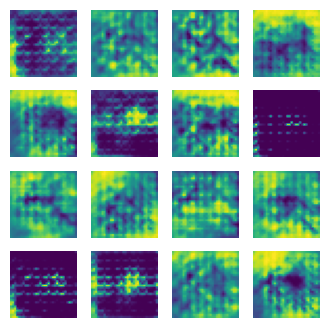

Time for training : 404 sec


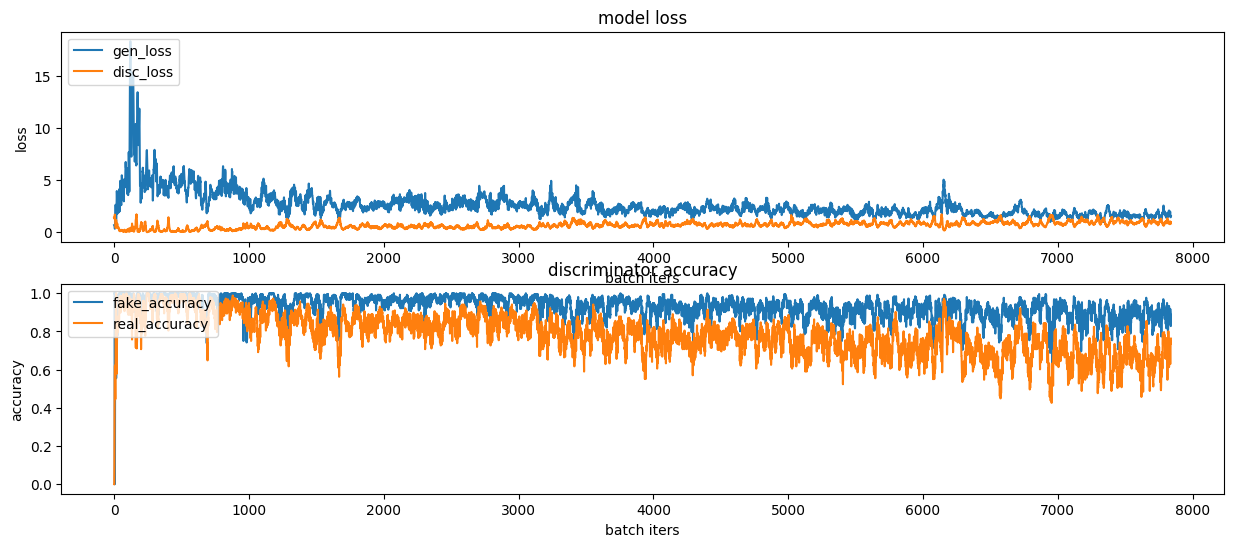

In [92]:
train_betav4(train_dataset, EPOCHS, save_every)

## skip connection 시도해보기

In [93]:
# ResNet Block 함수
def ResnetSkipBlock(x, filters, kernel_size, strides):
    # Initial input
    initial_x = x

    # First layer of the block
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Second layer of the block
    x = layers.Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Adding the skip connection
    x = layers.Add()([x, initial_x])
    x = layers.LeakyReLU()(x)

    return x

In [94]:
def make_generator_model_gamma():
    inputs = tf.keras.Input(shape=(255,))
    x = layers.Dense(8*8*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((8, 8, 256))(x)

    # Applying the first ResnetSkipBlock
    x = ResnetSkipBlock(x, 256, (4, 4), (1, 1))

    # Second block with strides to change dimensions
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final Conv2DTranspose layer
    x = layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [95]:
# 모델 summary 확인
generator_gamma = make_generator_model_gamma()

generator_gamma.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 16384)        4177920     ['input_1[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 16384)       65536       ['dense_11[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_31 (LeakyReLU)     (None, 16384)        0           ['batch_normalization_19[0][0

In [96]:
# 노이즈 벡터 만들기
# noise_beta = tf.random.normal([1, 255])
noise_dim = 255  # This should match the number of features expected by the generator
batch_size = 256  # This appears to be your batch size

# Generate noise with the correct shape
noise_gamma = np.random.normal(size=(batch_size, noise_dim))

In [97]:
# 훈련과 추론에서 BatchNorm 행동이달라 Training = False
generated_image_gamma = generator_gamma(noise_gamma, training=False)
generated_image_gamma.shape

TensorShape([256, 32, 32, 3])

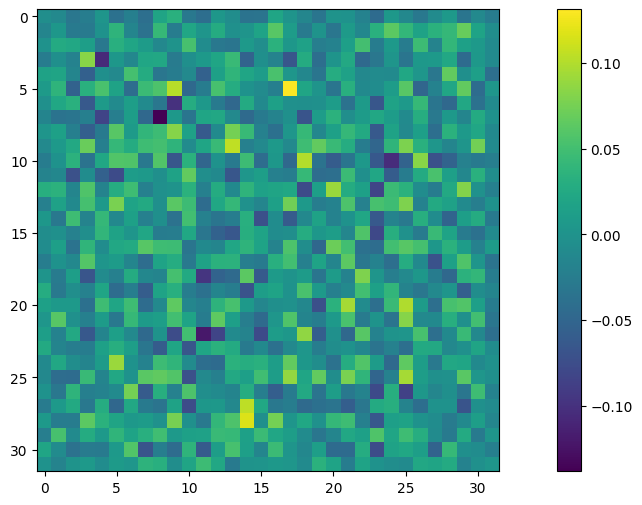

In [98]:
# 생성된 노이즈 이미지 뽑기
plt.imshow(generated_image_gamma[0, :, :, 0], cmap=None)
plt.colorbar()
plt.show()

In [99]:
# discriminator 재정의
discriminator_beta = make_discriminator_model()

discriminator_beta.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_13 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 8192)            

In [100]:
# (16, 100) 형상의 벡터를 만들기 위해 seed = 100 설
noise_dim_gamma = 255
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 255])

In [101]:
def generate_and_save_images_gamma(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='prism')
        plt.axis('off')

    cwd = os.getcwd()
    folder_path = os.path.join(cwd, r'cifar10\generated_samples')
    # plt.savefig(os.path.join(folder_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)))

    plt.show()

In [102]:
# Train Step
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step_gamma(images):
    noise = tf.random.normal([256, 255])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_gamma(noise, training=True)

        real_output = discriminator_beta(images, training=True)
        fake_output = discriminator_beta(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_gamma.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_beta.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_gamma.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_beta.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [103]:
checkpoint_dir_gamma = os.path.join(cwd, r'cifar10\training_checkpoints')

checkpoint_prefix_gamma = os.path.join(checkpoint_dir_gamma, "ckpt")
checkpoint_gamma = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [104]:
def train_gamma(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_gamma(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images_gamma(generator_gamma, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images_gamma(generator_gamma, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

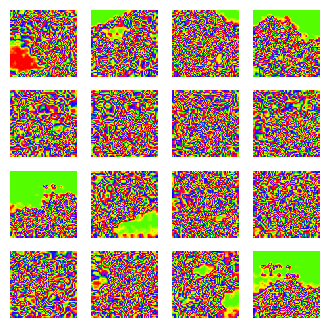

Time for training : 577 sec


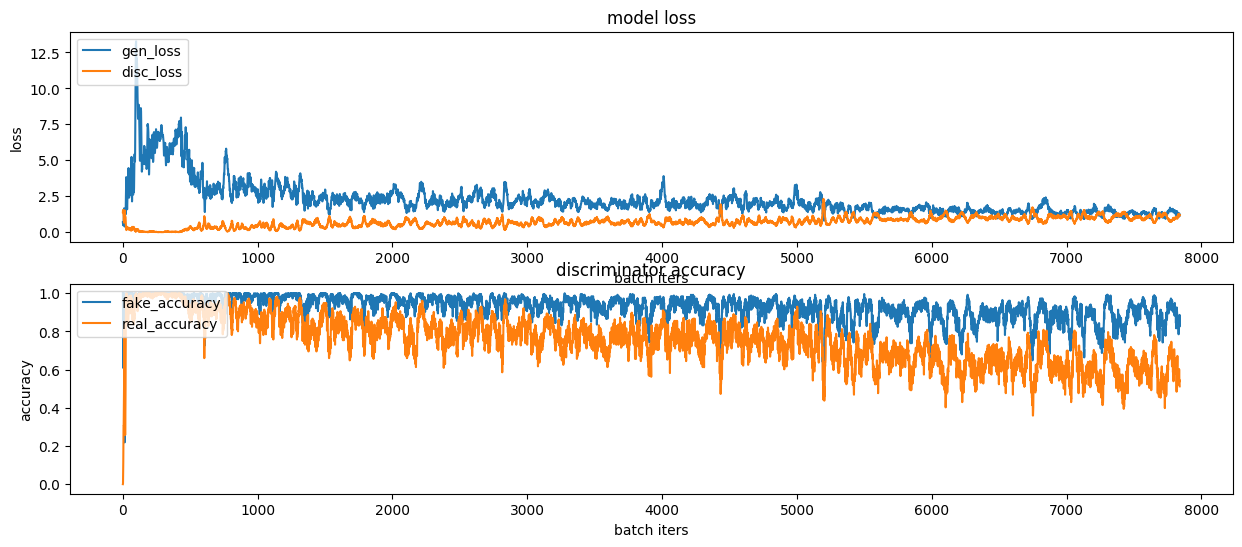

In [105]:
train_gamma(train_dataset, EPOCHS, save_every)